In [12]:
import mlrose_hiive as mlrose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import title

In [4]:
def generate_tsp_problem(number_of_cities=10, seed=None):
    """
    Generate a random Travelling Salesman Problem (TSP) with `num_cities`.
    
    Args:
    - num_cities (int): The number of cities (nodes) for the TSP.
    - seed (int or None): Seed for reproducibility. Default is None.
    
    Returns:
    - fitness: An instance of mlrose.TravellingSales fitness function.
    - coords: List of tuples representing city coordinates.
    """
    if seed is not None:
        np.random.seed(seed)

    coords = [(np.random.uniform(0, 100), np.random.uniform(0, 100)) for _ in range(number_of_cities)]
    fitness = mlrose.TravellingSales(coords=coords)
    
    return fitness, coords

In [13]:
def plot_fitness_iteration(problem_curves, title, x="Iteration", y="Fitness", algo_name=False):
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    for problem, curve in problem_curves:
        label = problem if algo_name else f'{problem.length}'
        plt.plot(range(len(curve)), curve[:, 0], label=label)
    plt.legend(loc="best")
    plt.show()

In [28]:
# Create list of city coordinates
coords_list = [(1, 1), (4, 2), (5, 2), (6, 4), (4, 4), (3, 6), (1, 5), (2, 3)]

# Initialize fitness function object using coords_list
fitness_coords = mlrose.TravellingSales(coords = coords_list)

In [6]:
# Create list of distances between pairs of cities
dist_list = [(0, 1, 3.1623), (0, 2, 4.1231), (0, 3, 5.8310), (0, 4, 4.2426), \
             (0, 5, 5.3852), (0, 6, 4.0000), (0, 7, 2.2361), (1, 2, 1.0000), \
             (1, 3, 2.8284), (1, 4, 2.0000), (1, 5, 4.1231), (1, 6, 4.2426), \
             (1, 7, 2.2361), (2, 3, 2.2361), (2, 4, 2.2361), (2, 5, 4.4721), \
             (2, 6, 5.0000), (2, 7, 3.1623), (3, 4, 2.0000), (3, 5, 3.6056), \
             (3, 6, 5.0990), (3, 7, 4.1231), (4, 5, 2.2361), (4, 6, 3.1623), \
             (4, 7, 2.2361), (5, 6, 2.2361), (5, 7, 3.1623), (6, 7, 2.2361)]

# Initialize fitness function object using dist_list
fitness_dists = mlrose.TravellingSales(distances = dist_list)

In [25]:
generate_problem = generate_tsp_problem(100)

In [26]:
# Define optimization problem object
# problem_fit = mlrose.TSPOpt(length = 8, fitness_fn = fitness_dists, maximize=False)
problem_fit = mlrose.TSPOpt(length = len(generate_problem[1]), fitness_fn = generate_problem[0], maximize=False)
problem_name = "TravellingSales_Problem"
output_dir = "TravellingSales"
random_state = 2024


[27 24 35  7 77 79 85 21 87 41  1 98 34 56  8 30 63 75 62 29  3 88 18 72
 15 76  9 67 11 64 19 39 20 82 22 42 47 83 97 54 86 44 16 53 52 38 49 84
 94 31 89 95 55 60 36 32  0 43 59 90 73 80 50 92 57 65 37 51 99  2 12 74
  4 48 13 81 25 46 66 40 23 10 96 58 78 68 93 26 45 69 71 91 14 70 61 33
  6 28 17  5]
2280.1185581754335


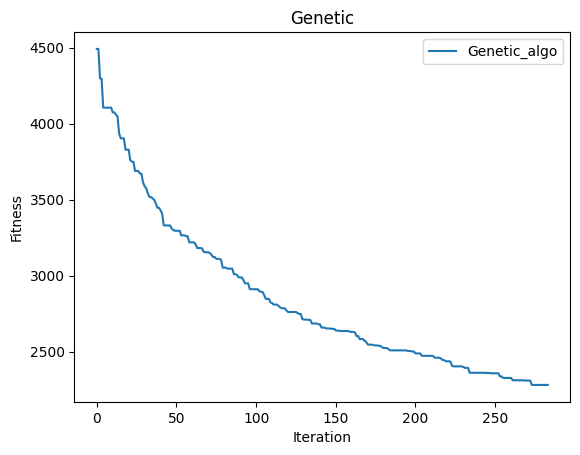

In [27]:
# Solve problem using the genetic algorithm
best_state, best_fitness , curve = mlrose.genetic_alg(problem_fit, random_state = 2, curve=True)

print(best_state)

print(best_fitness)
plot_fitness_iteration([('Genetic_algo', curve)], title='Genetic', algo_name=True)

[28 40 17 10 96 58 15 72 18 23 87 41  3 80 84 37 68 92 94  7 93 26 57 66
 49 38 56 11 45 98  1 95 67 47 48 78 13 65 50 42 46 14 77 88 25 81 76  5
 31 27 91 35 24 71  9 29 22 62 79 70  6 75 82 33  0 32 43 73 21 64 52 16
 55 12 19 60 30 20 63 39 90 59 61  8 36 53 51 99  4  2 54 44 74 86 97 34
 69 83 89 85]
1029.7365006409877


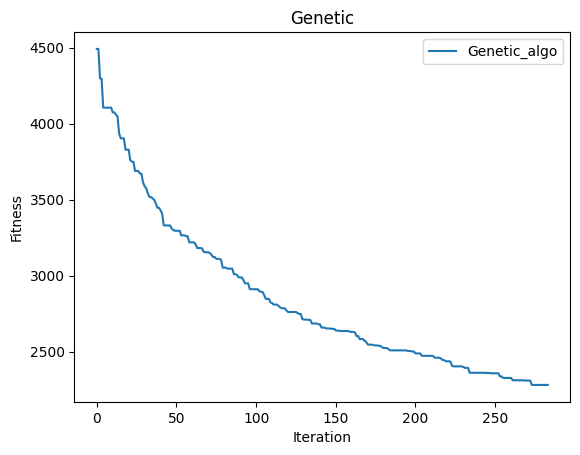

In [28]:
# Solve problem using the genetic algorithm
best_state, best_fitness , gcurve = mlrose.genetic_alg(problem_fit, mutation_prob = 0.2,
                                              max_attempts = 100, random_state = 2, curve=True)

print(best_state)

print(best_fitness)
plot_fitness_iteration([('Genetic_algo', curve)], title='Genetic', algo_name=True)

[80 85 33 66 93 37 36 59 74 44 73 39 63 30  8 32 28  6 70 61 52  2 51 98
 83 24 35 27  9 71 69 99 53 75 40 17 58 14  4 34 86 54 87 79 46 15 88 76
 26 81 25  5 31 77 23 41 96 10 22 84 95 19 60 55 12 64 21 82 20 90 43  0
  3 29 68 65 13 94 92 42 62 56 11 57  7 91 72 18 50 47  1 89 78 48 49 38
 45 16 97 67]
2401.640913514144


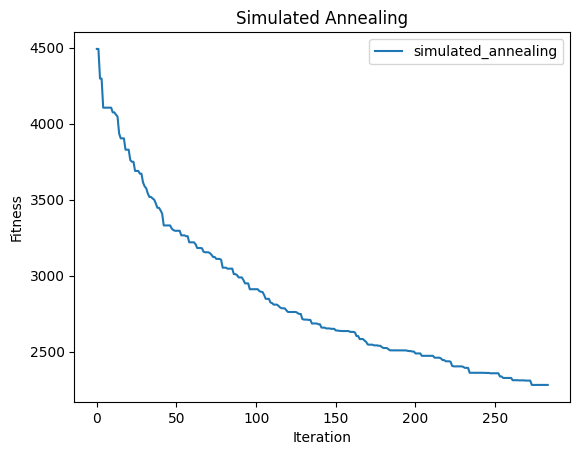

In [29]:

schedule = mlrose.ExpDecay()
best_state, best_fitness , sacurve = mlrose.simulated_annealing(problem_fit, schedule = schedule,max_attempts = 10000, max_iters = 1000, random_state = 1)
print(best_state)

print(best_fitness)
plot_fitness_iteration([('simulated_annealing', curve)], title='Simulated Annealing', algo_name=True)

In [21]:
mim = mlrose.MIMICRunner(problem=problem_fit,
                       experiment_name=problem_name,
                       output_directory=output_dir,
                       seed=random_state,
                       population_sizes=[50, 100, 200, 500, 1000, 2000],
                       keep_percent_list=[0.1, 0.25, 0.5, 0.7, 0.8],
                       iteration_list=[50],
                       use_fast_mimic=True)
mim_stats, mim_curve = mim.run()

In [24]:
show=10
columns = ['Time', 'Fitness', 'Population Size', 'Keep Percent']
pd.set_option('display.max_rows',show)
df=pd.read_csv("./TravellingSales/TravellingSales_Problem/mimic__TravellingSales_Problem__run_stats_df.csv")
df[columns].sort_values(by=['Fitness'], ascending=True).head(show)

,Time,Fitness,Population Size,Keep Percent
59,7.548991,17.3428,2000,0.80
31,1.872823,17.3428,500,0.10
33,1.850801,17.3428,500,0.25
13,0.379532,17.3428,100,0.25
35,2.618223,17.3428,500,0.50
37,2.443010,17.3428,500,0.70
39,3.005654,17.3428,500,0.80
25,0.832298,17.3428,200,0.50
41,3.549965,17.3428,1000,0.10
45,3.638015,17.3428,1000,0.50
